<a href="https://colab.research.google.com/github/andrealamanna/cnn_prediction_abnormalities_mammography/blob/main/Scratch_CNN_MassCalc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2**
## CNN for masses/calcifications classifications

#Perliminar phases

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns # Grouped bar plot
import itertools
import numpy as np
import pandas as pd 
import os 
import gc # Garbage Collector
from skimage import data, img_as_float
from skimage import exposure

from tensorflow import keras
from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from keras import layers, models, regularizers, metrics
from keras.models import load_model
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

print("Done")

Done


In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
#PAT = 4

METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

base_path = "/content/gdrive/My Drive/Colab Notebooks/DLProject/Lamanna/"

MODEL_PATH = os.path.join(base_path, "models/Scratch")
PLOTS_PATH = os.path.join(base_path, "plots/Scratch")
RESULT_PATH = os.path.join(base_path, "results/Masses-Calcifications/Scratch")

train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

#file_path_out = os.path.join(RESULT_PATH, "top3_results.csv")
#file_path = os.path.join(RESULT_PATH, "results-CM.csv")
#model_path = os.path.join(MODEL_PATH, "best_model.h5")

print("Done")

Done


# Utility Functions

In [ ]:
# Remove baseline samples
def remove_baseline(samples): 
  max_index = int(len(samples)/2)
  indexes = [2*i + 1 for i in range(0, max_index)]

  return samples[indexes]

# Interchange the dataset index
def shuffle_dataset(i, j):
  indexes = tf.range(start=0, limit=tf.shape(i)[0], dtype=tf.int32)
  shuffled_indexes = tf.random.shuffle(indexes)

  i = tf.gather(i, shuffled_indexes)
  j = tf.gather(j, shuffled_indexes)

  i = i.numpy()
  j = j.numpy()

  return i, j

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
    # Calcifications
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

Done


In [ ]:
#test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
def test_model(model):
  test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE)#,
                                      #callbacks=[GarbageCollectorCallback()])
  print("\n---------------------------------")
  print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
  print("Loss:", "%0.2f" % (test_loss*100), "%")
  #print("Precision:", "%0.2f" % (test_precision*100), "%")
  #print("Recall:", "%0.2f" % (test_recall*100), "%")
  #print("AUC:", "%0.2f" % test_auc)
  print("---------------------------------\n")

print("Done")

Done


In [ ]:
def print_opt_results(history_0):
  # History of accuracy and loss
  tra_loss_0 = history_0.history['loss']
  tra_acc_0 = history_0.history['acc']
  val_loss_0 = history_0.history['val_loss']
  val_acc_0 = history_0.history['val_acc']

  # Total number of epochs training
  epochs_0 = range(1, len(tra_acc_0)+1)
  end_epoch_0 = len(tra_acc_0)

  # Epoch when reached the val acc max
  opt_epoch_0 = val_acc_0.index(max(val_acc_0)) + 1

  # Loss and accuracy on the validation set
  end_val_loss_0 = val_loss_0[len(val_loss_0)-1]
  end_val_acc_0 = val_acc_0[len(val_acc_0)-1]
  opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
  opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

  print("Epoch [end]: %d" % end_epoch_0)
  print("Epoch [opt]: %d" % opt_epoch_0)
  print("Valid accuracy [end]: %.4f" % end_val_acc_0)
  print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
  print("Valid loss [end]: %.4f" % end_val_loss_0)
  print("Valid loss [opt]: %.4f" % opt_val_loss_0)

print("Done")

Done


In [ ]:
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  #loss = history.history['loss']
  #val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.figure()
  plt.plot(epochs, acc, 'b', linestyle='dashed', label='Training accuracy',color='Green')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='Blue')
  plt.title('Training and validation accuracy')
  plt.legend()
  return plt

def plot_loss(history):
  #acc = history.history['acc']
  #val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', linestyle='dashed', label='Training loss',color='cyan')
  plt.plot(epochs, val_loss, 'b', label='Validation loss',color='orange')
  plt.title('Training and validation loss')
  plt.legend()
  return plt

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    precision = TP / (TP + FP)

    tpr = TP / (TP + FN)
    specificity = TN / (TN + FP)
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity
    # Visualization Data Histogram

def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=BATCH_SIZE+1,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt

print("Done")

Done


In [ ]:
#Early stop conditon 
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PAT)

In [ ]:
# Custom Callback To Include in Callbacks List At Training Time
#class GarbageCollectorCallback(tf.keras.callbacks.Callback):
#    def on_epoch_end(self, epoch, logs=None):
#      gc.collect()

#print("Done")

# Data operations

In [ ]:
train_images = np.load(train_img_path)
train_labels = np.load(train_label_path)
test_images = np.load(test_img_path)
test_labels = np.load(test_label_path)

#count quantity masses and calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)
print("Train dataset")
print("---------------------------------")
print("Masses: \t\t", counts[1]+counts[2])
print("Calcification: \t\t", counts[3]+counts[4])
print("---------------------------------")
print("Benign: \t\t", counts[1]+counts[3])
print("Malign: \t\t", counts[2]+counts[4])
print("---------------------------------")
print("Benign Masses: \t\t", counts[1])
print("Malign Masses: \t\t", counts[2])
print("Benign Calcification: \t", counts[3])
print("Malign Calcification: \t", counts[4])
print("---------------------------------")
print("Baseline: \t\t", counts[0])
print("---------------------------------")
print("Total: \t\t\t", counts[0]+counts[1]+counts[2]+counts[3]+counts[4])

#count quantity masses and calcifications
uniqueT, countsT = np.unique(test_labels, return_counts=True)
#print(unique, countsT)
print("\n")
print("Test dataset")
print("---------------------------------")
print("Masses: \t\t", countsT[1]+countsT[2])
print("Calcification: \t\t", countsT[3]+countsT[4])
print("---------------------------------")
print("Benign: \t\t", countsT[1]+countsT[3])
print("Malign: \t\t", countsT[2]+countsT[4])
print("---------------------------------")
print("Benign Masses: \t\t", countsT[1])
print("Malign Masses: \t\t", countsT[2])
print("Benign Calcification: \t", countsT[3])
print("Malign Calcification: \t", countsT[4])
print("---------------------------------")
print("Baseline: \t\t", countsT[0])
print("---------------------------------")
print("Total: \t\t\t", countsT[0]+countsT[1]+countsT[2]+countsT[3]+countsT[4])

Train dataset
---------------------------------
Masses: 		 1218
Calcification: 		 1458
---------------------------------
Benign: 		 1568
Malign: 		 1108
---------------------------------
Benign Masses: 		 620
Malign Masses: 		 598
Benign Calcification: 	 948
Malign Calcification: 	 510
---------------------------------
Baseline: 		 2676
---------------------------------
Total: 			 5352


Test dataset
---------------------------------
Masses: 		 179
Calcification: 		 157
---------------------------------
Benign: 		 219
Malign: 		 117
---------------------------------
Benign Masses: 		 113
Malign Masses: 		 66
Benign Calcification: 	 106
Malign Calcification: 	 51
---------------------------------
Baseline: 		 336
---------------------------------
Total: 			 672


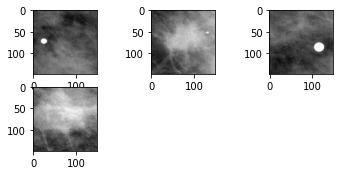

In [ ]:
images = range(0,4)
for i in images:
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
    
#Show the plot
plt.show()

In [ ]:
# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Mapping labels with standard index
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

# Suffle index (Previous dataset is ordered by index)
train_images, train_labels = shuffle_dataset(train_images, train_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


In [ ]:
# Prepare the data with the expected format
train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150, 1)
Test shape:  (336, 150, 150, 1)


In [ ]:
#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Masses samples: ", counts[0])
print("Calcifications samples: ", counts[1])

Masses samples:  1218
Calcifications samples:  1458


In [ ]:
#Splitting training-validation with 80-20 %
split_index = int(0.8*len(train_images))
train_dataset_split = train_images[:split_index]
valid_dataset_split = train_images[split_index:]
train_labels_split = train_labels[:split_index]
valid_labels_split = train_labels[split_index:]

print(train_dataset_split.shape)
print(valid_dataset_split.shape)

(2140, 150, 150, 1)
(536, 150, 150, 1)


In [ ]:
# All images will be rescaled by 1./65535 (max value range)
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535)

# **CNN Definition**

## Model 1
Simple model

In [ ]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation="relu"))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 73984)            

In [ ]:
history1 = model1.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 16s 82ms/step - loss: 0.9010 - acc: 0.5228 - val_loss: 0.7712 - val_acc: 0.5488
Epoch 2/100
66/66 [==============================] - 5s 71ms/step - loss: 0.7153 - acc: 0.5337 - val_loss: 0.6841 - val_acc: 0.5488
Epoch 3/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6951 - acc: 0.5299 - val_loss: 0.6822 - val_acc: 0.5488
Epoch 4/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6965 - acc: 0.5308 - val_loss: 0.6765 - val_acc: 0.6289
Epoch 5/100
66/66 [==============================] - 5s 72ms/step - loss: 0.6893 - acc: 0.5963 - val_loss: 0.6491 - val_acc: 0.7090
Epoch 6/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6434 - acc: 0.6480 - val_loss: 0.5527 - val_acc: 0.7402
Epoch 7/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6058 - acc: 0.7045 - val_loss: 0.5609 - val_acc: 0.7012
Epoch 8/100
66/66 [==============================] - 4s 68ms/step - loss: 0

In [ ]:
model1.save(os.path.join(MODEL_PATH,'calcmasses_model1.h5'))

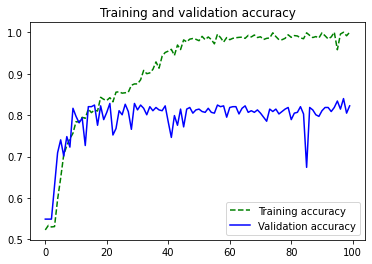

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history1)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calc_masses_model_1_acc.png'))

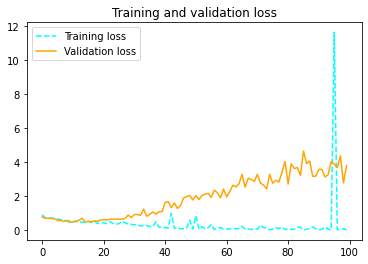

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history1)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calc_masses_model_1_loss.png'))

In [ ]:
print_opt_results(history1)

Epoch [end]: 100
Epoch [opt]: 98
Valid accuracy [end]: 0.8223
Valid accuracy [opt]: 0.8398
Valid loss [end]: 3.7861
Valid loss [opt]: 4.3726


In [ ]:
test_model(model1)

10/10 [==============================] - 0s 22ms/step - loss: 3.8650 - acc: 0.7937

---------------------------------
Accuracy: 79.37 %
Loss: 386.50 %
---------------------------------



## Data Augmentation

In [ ]:
# Train data augmentation. Deep Convolutional Neural Networks for breast cancer screening. Hiba Chougrada, Hamid Zouaki, Omar Alheyane b
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    zoom_range=0.5, #0.5 - 1.5
    horizontal_flip=True,
    fill_mode='nearest')

## Model 1.1
Simple model with data augmentation

In [ ]:
model11 = models.Sequential()
model11.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Conv2D(64, (3, 3), activation='relu'))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Conv2D(64, (3, 3), activation='relu'))
model11.add(layers.Flatten())
model11.add(layers.Dense(64, activation="relu"))
model11.add(layers.Dense(1, activation='sigmoid'))

model11.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model11.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 73984)            

In [ ]:
history11 = model11.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 100ms/step - loss: 0.9072 - acc: 0.5327 - val_loss: 0.6906 - val_acc: 0.5488
Epoch 2/100
66/66 [==============================] - 6s 97ms/step - loss: 0.7093 - acc: 0.5199 - val_loss: 0.6891 - val_acc: 0.5488
Epoch 3/100
66/66 [==============================] - 6s 97ms/step - loss: 0.6991 - acc: 0.5474 - val_loss: 0.6841 - val_acc: 0.5488
Epoch 4/100
66/66 [==============================] - 6s 97ms/step - loss: 0.6891 - acc: 0.5631 - val_loss: 0.6688 - val_acc: 0.5723
Epoch 5/100
66/66 [==============================] - 6s 98ms/step - loss: 0.6746 - acc: 0.6001 - val_loss: 0.6453 - val_acc: 0.5762
Epoch 6/100
66/66 [==============================] - 6s 97ms/step - loss: 0.6520 - acc: 0.6395 - val_loss: 0.8087 - val_acc: 0.5254
Epoch 7/100
66/66 [==============================] - 6s 98ms/step - loss: 0.6450 - acc: 0.6437 - val_loss: 0.5467 - val_acc: 0.7539
Epoch 8/100
66/66 [==============================] - 6s 97ms/step - loss: 0

In [ ]:
model11.save(os.path.join(MODEL_PATH,'calcmasses_model1_da.h5'))

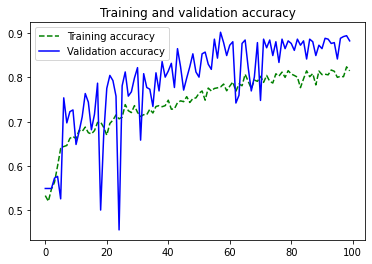

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history11)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_da_acc.png'))

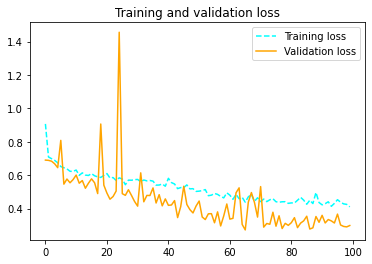

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history11)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_da_loss.png'))

In [ ]:
print_opt_results(history11)

Epoch [end]: 100
Epoch [opt]: 58
Valid accuracy [end]: 0.8828
Valid accuracy [opt]: 0.9023
Valid loss [end]: 0.2990
Valid loss [opt]: 0.2964


In [ ]:
test_model(model11)

10/10 [==============================] - 0s 22ms/step - loss: 0.3248 - acc: 0.8594

---------------------------------
Accuracy: 85.94 %
Loss: 32.48 %
---------------------------------



## Model 1.2
Simple model with data augmentation and dropout



*   Dropout 0.5



In [ ]:
model12 = models.Sequential()
model12.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model12.add(layers.MaxPooling2D((2, 2)))
model12.add(layers.Conv2D(64, (3, 3), activation='relu'))
model12.add(layers.MaxPooling2D((2, 2)))
model12.add(layers.Conv2D(64, (3, 3), activation='relu'))
model12.add(layers.Flatten())
model12.add(layers.Dense(64, activation="relu"))
model12.add(layers.Dropout(0.5))
model12.add(layers.Dense(1, activation='sigmoid'))

model12.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model12.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 73984)            

In [ ]:
history12 = model12.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 99ms/step - loss: 0.7532 - acc: 0.5232 - val_loss: 0.6905 - val_acc: 0.5488
Epoch 2/100
66/66 [==============================] - 7s 100ms/step - loss: 0.7046 - acc: 0.5280 - val_loss: 0.6891 - val_acc: 0.4980
Epoch 3/100
66/66 [==============================] - 6s 96ms/step - loss: 0.6959 - acc: 0.5380 - val_loss: 0.7187 - val_acc: 0.5488
Epoch 4/100
66/66 [==============================] - 6s 95ms/step - loss: 0.7006 - acc: 0.5384 - val_loss: 0.6829 - val_acc: 0.4902
Epoch 5/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6972 - acc: 0.5332 - val_loss: 0.6815 - val_acc: 0.5488
Epoch 6/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6910 - acc: 0.5451 - val_loss: 0.6855 - val_acc: 0.5547
Epoch 7/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6906 - acc: 0.5498 - val_loss: 0.6738 - val_acc: 0.7070
Epoch 8/100
66/66 [==============================] - 6s 95ms/step - loss: 0

In [ ]:
model12.save(os.path.join(MODEL_PATH,'calcmasses_model1_d5.h5'))

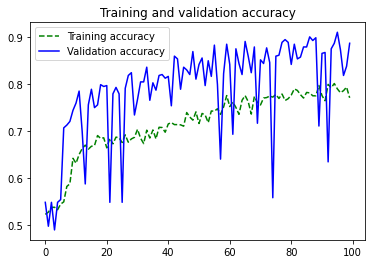

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history12)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d5_acc.png'))

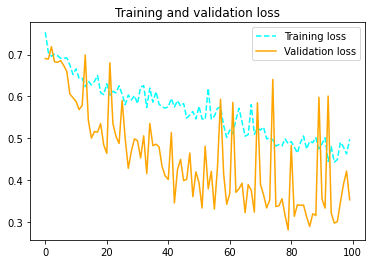

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history12)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d5_loss.png'))

In [ ]:
print_opt_results(history12)

Epoch [end]: 100
Epoch [opt]: 96
Valid accuracy [end]: 0.8867
Valid accuracy [opt]: 0.9102
Valid loss [end]: 0.3535
Valid loss [opt]: 0.3015


In [ ]:
test_model(model12)

10/10 [==============================] - 0s 22ms/step - loss: 0.3873 - acc: 0.8687

---------------------------------
Accuracy: 86.87 %
Loss: 38.73 %
---------------------------------



In [ ]:
model12 = models.Sequential()
model12.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model12.add(layers.MaxPooling2D((2, 2)))
model12.add(layers.Conv2D(64, (3, 3), activation='relu'))
model12.add(layers.MaxPooling2D((2, 2)))
model12.add(layers.Conv2D(64, (3, 3), activation='relu'))
model12.add(layers.Flatten())
model12.add(layers.Dropout(0.5))
model12.add(layers.Dense(64, activation="relu"))
model12.add(layers.Dense(1, activation='sigmoid'))

model12.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model12.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 73984)             0

In [ ]:
history12 = model12.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 24s 167ms/step - loss: 0.8806 - acc: 0.5332 - val_loss: 0.8461 - val_acc: 0.5352
Epoch 2/100
66/66 [==============================] - 6s 91ms/step - loss: 0.6942 - acc: 0.5351 - val_loss: 0.6908 - val_acc: 0.5352
Epoch 3/100
66/66 [==============================] - 6s 92ms/step - loss: 0.6977 - acc: 0.5361 - val_loss: 0.6869 - val_acc: 0.5352
Epoch 4/100
66/66 [==============================] - 7s 107ms/step - loss: 0.6928 - acc: 0.5422 - val_loss: 0.6900 - val_acc: 0.5352
Epoch 5/100
66/66 [==============================] - 6s 94ms/step - loss: 0.6935 - acc: 0.5455 - val_loss: 0.6875 - val_acc: 0.5352
Epoch 6/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6897 - acc: 0.5408 - val_loss: 0.6866 - val_acc: 0.5352
Epoch 7/100
66/66 [==============================] - 6s 91ms/step - loss: 0.6882 - acc: 0.5446 - val_loss: 0.6881 - val_acc: 0.5352
Epoch 8/100
66/66 [==============================] - 6s 92ms/step - loss:

In [ ]:
model12.save(os.path.join(MODEL_PATH,'calcmasses_model13_d5.h5'))

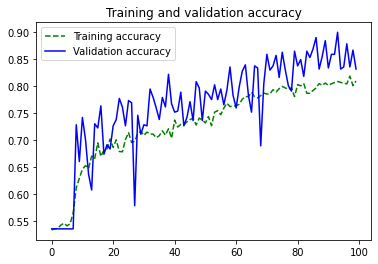

In [ ]:
plt_a = plot_acc(history12)
plt_a.show()
#plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d5_acc.png'))

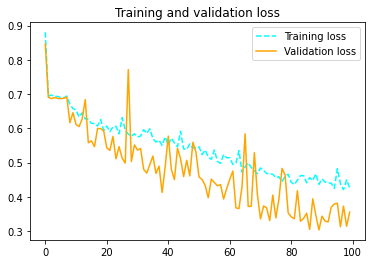

In [ ]:
plt_l = plot_loss(history12)
plt_l.show()
#plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d5_loss.png'))

In [ ]:
print_opt_results(history12)

Epoch [end]: 100
Epoch [opt]: 94
Valid accuracy [end]: 0.8320
Valid accuracy [opt]: 0.9004
Valid loss [end]: 0.3556
Valid loss [opt]: 0.3698


In [ ]:
test_model(model12)

10/10 [==============================] - 0s 20ms/step - loss: 0.3993 - acc: 0.8313

---------------------------------
Accuracy: 83.13 %
Loss: 39.93 %
---------------------------------



##Model 1.3

*   Dropout 0.2



In [ ]:
model13 = models.Sequential()
model13.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model13.add(layers.MaxPooling2D((2, 2)))
model13.add(layers.Conv2D(64, (3, 3), activation='relu'))
model13.add(layers.MaxPooling2D((2, 2)))
model13.add(layers.Conv2D(64, (3, 3), activation='relu'))
model13.add(layers.Flatten())
model13.add(layers.Dense(64, activation="relu"))
model13.add(layers.Dropout(0.2))
model13.add(layers.Dense(1, activation='sigmoid'))

model13.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model13.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_4 (Flatten)         (None, 73984)            

In [ ]:
history13 = model13.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 7s 98ms/step - loss: 0.9365 - acc: 0.5147 - val_loss: 0.6953 - val_acc: 0.5488
Epoch 2/100
66/66 [==============================] - 6s 94ms/step - loss: 0.7001 - acc: 0.5152 - val_loss: 0.6908 - val_acc: 0.5508
Epoch 3/100
66/66 [==============================] - 6s 93ms/step - loss: 0.7370 - acc: 0.5351 - val_loss: 0.6878 - val_acc: 0.5469
Epoch 4/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6930 - acc: 0.5365 - val_loss: 0.6793 - val_acc: 0.5469
Epoch 5/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6930 - acc: 0.5389 - val_loss: 0.6890 - val_acc: 0.5488
Epoch 6/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6985 - acc: 0.5432 - val_loss: 0.6854 - val_acc: 0.5488
Epoch 7/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6930 - acc: 0.5275 - val_loss: 0.6797 - val_acc: 0.5488
Epoch 8/100
66/66 [==============================] - 6s 94ms/step - loss: 0.

In [ ]:
model13.save(os.path.join(MODEL_PATH,'calcmasses_model1_d2.h5'))

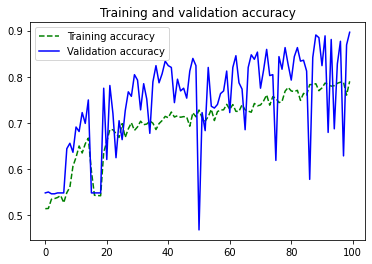

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history13)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d2_acc.png'))

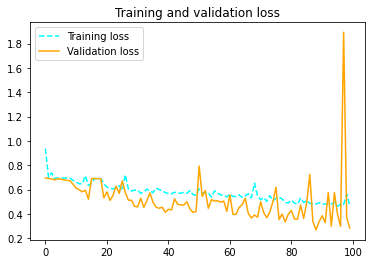

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history13)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d2_loss.png'))

In [ ]:
print_opt_results(history13)

Epoch [end]: 100
Epoch [opt]: 100
Valid accuracy [end]: 0.8965
Valid accuracy [opt]: 0.8965
Valid loss [end]: 0.2845
Valid loss [opt]: 0.2845


In [ ]:
test_model(model13)

10/10 [==============================] - 0s 22ms/step - loss: 0.3436 - acc: 0.8531

---------------------------------
Accuracy: 85.31 %
Loss: 34.36 %
---------------------------------



In [ ]:
model13 = models.Sequential()
model13.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model13.add(layers.MaxPooling2D((2, 2)))
model13.add(layers.Conv2D(64, (3, 3), activation='relu'))
model13.add(layers.MaxPooling2D((2, 2)))
model13.add(layers.Conv2D(64, (3, 3), activation='relu'))
model13.add(layers.Flatten())
model13.add(layers.Dropout(0.2))
model13.add(layers.Dense(64, activation="relu"))
model13.add(layers.Dense(1, activation='sigmoid'))

model13.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 73984)            

In [ ]:
history13 = model13.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 7s 93ms/step - loss: 0.8426 - acc: 0.5417 - val_loss: 0.6967 - val_acc: 0.5352
Epoch 2/100
66/66 [==============================] - 6s 90ms/step - loss: 0.7043 - acc: 0.5247 - val_loss: 0.6915 - val_acc: 0.5352
Epoch 3/100
66/66 [==============================] - 6s 90ms/step - loss: 0.6926 - acc: 0.5384 - val_loss: 0.6962 - val_acc: 0.5352
Epoch 4/100
66/66 [==============================] - 6s 89ms/step - loss: 0.7284 - acc: 0.5432 - val_loss: 0.6922 - val_acc: 0.5352
Epoch 5/100
66/66 [==============================] - 6s 89ms/step - loss: 0.6893 - acc: 0.5380 - val_loss: 0.7130 - val_acc: 0.5352
Epoch 6/100
66/66 [==============================] - 6s 89ms/step - loss: 0.6904 - acc: 0.5484 - val_loss: 0.6890 - val_acc: 0.5352
Epoch 7/100
66/66 [==============================] - 6s 89ms/step - loss: 0.6919 - acc: 0.5484 - val_loss: 0.6985 - val_acc: 0.5352
Epoch 8/100
66/66 [==============================] - 6s 89ms/step - loss: 0.

In [ ]:
model13.save(os.path.join(MODEL_PATH,'calcmasses_model13_d2.h5'))

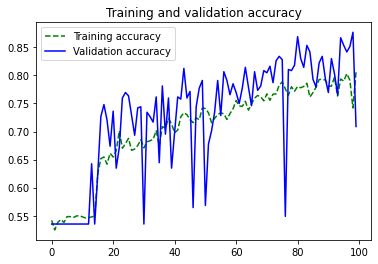

In [ ]:
plt_a = plot_acc(history13)
plt_a.show()
#plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d2_acc.png'))

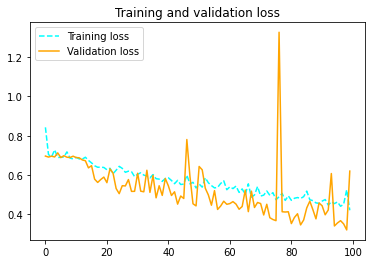

In [ ]:
plt_l = plot_loss(history13)
plt_l.show()
#plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d2_loss.png'))

In [ ]:
print_opt_results(history13)

Epoch [end]: 100
Epoch [opt]: 99
Valid accuracy [end]: 0.7090
Valid accuracy [opt]: 0.8770
Valid loss [end]: 0.6203
Valid loss [opt]: 0.3214


In [ ]:
test_model(model13)

10/10 [==============================] - 0s 19ms/step - loss: 0.6529 - acc: 0.7125

---------------------------------
Accuracy: 71.25 %
Loss: 65.29 %
---------------------------------



##Model 1.4

*   Dropout 0.1



In [ ]:
model14 = models.Sequential()
model14.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model14.add(layers.MaxPooling2D((2, 2)))
model14.add(layers.Conv2D(64, (3, 3), activation='relu'))
model14.add(layers.MaxPooling2D((2, 2)))
model14.add(layers.Conv2D(64, (3, 3), activation='relu'))
model14.add(layers.Flatten())
model14.add(layers.Dense(64, activation="relu"))
model14.add(layers.Dropout(0.1))
model14.add(layers.Dense(1, activation='sigmoid'))

model14.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model14.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_8 (Flatten)         (None, 73984)            

In [ ]:
history14 = model14.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 101ms/step - loss: 0.7921 - acc: 0.5033 - val_loss: 0.6821 - val_acc: 0.5488
Epoch 2/100
66/66 [==============================] - 6s 97ms/step - loss: 0.7038 - acc: 0.5365 - val_loss: 0.6875 - val_acc: 0.4902
Epoch 3/100
66/66 [==============================] - 6s 98ms/step - loss: 0.7081 - acc: 0.5304 - val_loss: 0.6813 - val_acc: 0.5527
Epoch 4/100
66/66 [==============================] - 7s 102ms/step - loss: 0.6910 - acc: 0.5370 - val_loss: 0.6838 - val_acc: 0.5488
Epoch 5/100
66/66 [==============================] - 7s 98ms/step - loss: 0.6944 - acc: 0.5503 - val_loss: 0.6629 - val_acc: 0.5723
Epoch 6/100
66/66 [==============================] - 6s 97ms/step - loss: 0.6729 - acc: 0.5906 - val_loss: 0.5930 - val_acc: 0.7441
Epoch 7/100
66/66 [==============================] - 6s 98ms/step - loss: 0.6574 - acc: 0.6243 - val_loss: 0.5851 - val_acc: 0.7383
Epoch 8/100
66/66 [==============================] - 7s 98ms/step - loss: 

In [ ]:
model14.save(os.path.join(MODEL_PATH,'calcmasses_model1_d1.h5'))

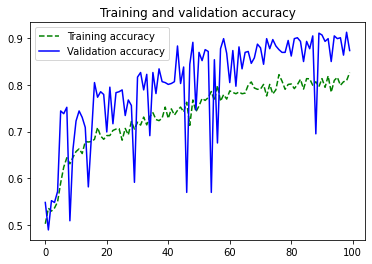

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history14)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d1_acc.png'))

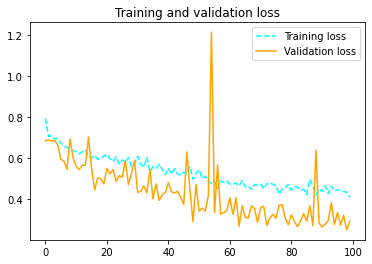

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history14)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d1_loss.png'))

In [ ]:
print_opt_results(history14)

Epoch [end]: 100
Epoch [opt]: 99
Valid accuracy [end]: 0.8730
Valid accuracy [opt]: 0.9121
Valid loss [end]: 0.2915
Valid loss [opt]: 0.2484


In [ ]:
test_model(model14)

10/10 [==============================] - 0s 21ms/step - loss: 0.3787 - acc: 0.8250

---------------------------------
Accuracy: 82.50 %
Loss: 37.87 %
---------------------------------



##Model 1.5

*   Dropout 0.5 e 0.5


In [ ]:
model15 = models.Sequential()
model15.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model15.add(layers.MaxPooling2D((2, 2)))
model15.add(layers.Conv2D(64, (3, 3), activation='relu'))
model15.add(layers.MaxPooling2D((2, 2)))
model15.add(layers.Conv2D(64, (3, 3), activation='relu'))
model15.add(layers.Flatten())
model15.add(layers.Dropout(0.5))
model15.add(layers.Dense(64, activation="relu"))
model15.add(layers.Dropout(0.5))
model15.add(layers.Dense(1, activation='sigmoid'))

model15.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model15.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 73984)            

In [ ]:
history15 = model15.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 14s 176ms/step - loss: 0.7093 - acc: 0.5223 - val_loss: 0.6911 - val_acc: 0.5352
Epoch 2/100
66/66 [==============================] - 10s 149ms/step - loss: 0.6917 - acc: 0.5237 - val_loss: 0.6878 - val_acc: 0.5352
Epoch 3/100
66/66 [==============================] - 10s 145ms/step - loss: 0.7102 - acc: 0.5451 - val_loss: 0.6891 - val_acc: 0.4785
Epoch 4/100
66/66 [==============================] - 9s 134ms/step - loss: 0.6900 - acc: 0.5361 - val_loss: 0.6883 - val_acc: 0.5352
Epoch 5/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6915 - acc: 0.5493 - val_loss: 0.6865 - val_acc: 0.5352
Epoch 6/100
66/66 [==============================] - 6s 92ms/step - loss: 0.6943 - acc: 0.5484 - val_loss: 0.6908 - val_acc: 0.5352
Epoch 7/100
66/66 [==============================] - 6s 91ms/step - loss: 0.6893 - acc: 0.5455 - val_loss: 0.7123 - val_acc: 0.5352
Epoch 8/100
66/66 [==============================] - 6s 92ms/step - l

In [ ]:
model15.save(os.path.join(MODEL_PATH,'calcmasses_model15_d1.h5'))

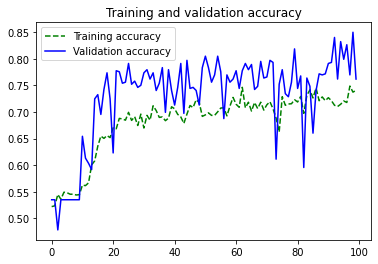

In [ ]:
plt_a = plot_acc(history15)
plt_a.show()
#plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model15_d1_acc.png'))

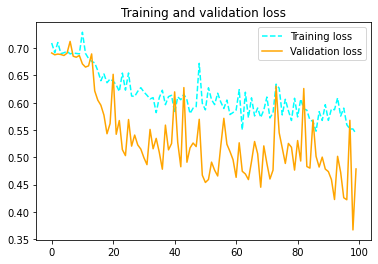

In [ ]:
plt_l = plot_loss(history15)
plt_l.show()
#plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model1_d1_loss.png'))

In [ ]:
print_opt_results(history15)

Epoch [end]: 100
Epoch [opt]: 99
Valid accuracy [end]: 0.7617
Valid accuracy [opt]: 0.8496
Valid loss [end]: 0.4787
Valid loss [opt]: 0.3670


In [ ]:
test_model(model15)

10/10 [==============================] - 0s 19ms/step - loss: 0.5161 - acc: 0.7375

---------------------------------
Accuracy: 73.75 %
Loss: 51.61 %
---------------------------------



## Model 2
More complex model with dropout 0.2

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_9 (Flatten)         (None, 147968)           

In [ ]:
history2 = model2.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 108ms/step - loss: 0.9269 - acc: 0.5308 - val_loss: 0.6847 - val_acc: 0.5488
Epoch 2/100
66/66 [==============================] - 7s 101ms/step - loss: 0.6958 - acc: 0.5365 - val_loss: 0.6867 - val_acc: 0.5488
Epoch 3/100
66/66 [==============================] - 7s 101ms/step - loss: 0.6930 - acc: 0.5380 - val_loss: 0.6794 - val_acc: 0.5918
Epoch 4/100
66/66 [==============================] - 7s 102ms/step - loss: 0.6934 - acc: 0.5451 - val_loss: 0.6756 - val_acc: 0.5488
Epoch 5/100
66/66 [==============================] - 7s 102ms/step - loss: 0.6928 - acc: 0.5602 - val_loss: 0.6672 - val_acc: 0.7090
Epoch 6/100
66/66 [==============================] - 7s 100ms/step - loss: 0.6721 - acc: 0.6105 - val_loss: 0.6321 - val_acc: 0.6992
Epoch 7/100
66/66 [==============================] - 7s 101ms/step - loss: 0.6644 - acc: 0.6129 - val_loss: 0.6332 - val_acc: 0.6387
Epoch 8/100
66/66 [==============================] - 7s 100ms/step - 

In [ ]:
model2.save(os.path.join(MODEL_PATH,'calcmasses_model2.h5'))

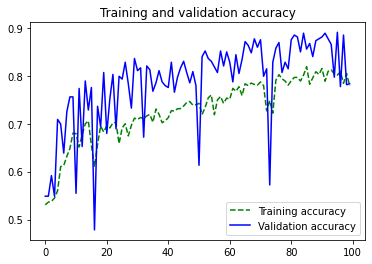

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history2)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model2_acc.png'))

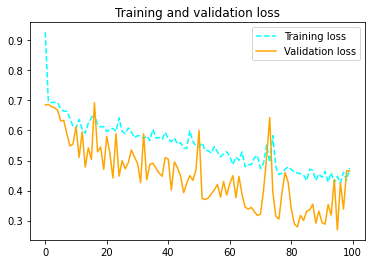

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history2)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model2_loss.png'))

In [ ]:
print_opt_results(history2)

Epoch [end]: 100
Epoch [opt]: 96
Valid accuracy [end]: 0.7832
Valid accuracy [opt]: 0.8906
Valid loss [end]: 0.4657
Valid loss [opt]: 0.2690


In [ ]:
test_model(model2)

10/10 [==============================] - 0s 24ms/step - loss: 0.5365 - acc: 0.7406

---------------------------------
Accuracy: 74.06 %
Loss: 53.65 %
---------------------------------



## Model 3
More complex (added a layer to cnn) model with dropout 0.2

In [ ]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation="relu"))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 17, 17, 128)    

In [ ]:
history3 = model3.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 103ms/step - loss: 0.7295 - acc: 0.5308 - val_loss: 0.6904 - val_acc: 0.5488
Epoch 2/100
66/66 [==============================] - 7s 99ms/step - loss: 0.7089 - acc: 0.5460 - val_loss: 0.6879 - val_acc: 0.5488
Epoch 3/100
66/66 [==============================] - 7s 98ms/step - loss: 0.7073 - acc: 0.5451 - val_loss: 0.6802 - val_acc: 0.5488
Epoch 4/100
66/66 [==============================] - 7s 98ms/step - loss: 0.6957 - acc: 0.5380 - val_loss: 0.6813 - val_acc: 0.5488
Epoch 5/100
66/66 [==============================] - 7s 99ms/step - loss: 0.6921 - acc: 0.5446 - val_loss: 0.6893 - val_acc: 0.5488
Epoch 6/100
66/66 [==============================] - 7s 99ms/step - loss: 0.7023 - acc: 0.5479 - val_loss: 0.6830 - val_acc: 0.5488
Epoch 7/100
66/66 [==============================] - 7s 98ms/step - loss: 0.6942 - acc: 0.5455 - val_loss: 0.6879 - val_acc: 0.5488
Epoch 8/100
66/66 [==============================] - 6s 98ms/step - loss: 0

In [ ]:
model3.save(os.path.join(MODEL_PATH,'calcmasses_model3.h5'))

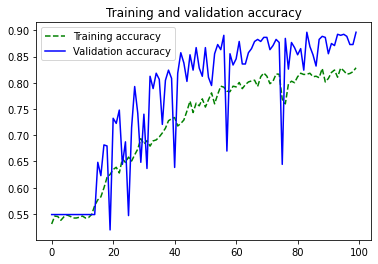

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history3)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model3_acc.png'))

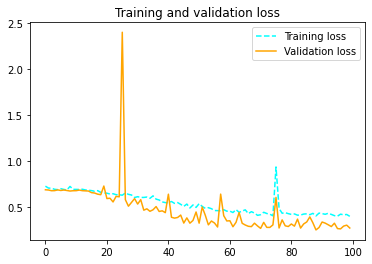

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history3)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model3_loss.png'))

In [ ]:
print_opt_results(history3)

Epoch [end]: 100
Epoch [opt]: 84
Valid accuracy [end]: 0.8965
Valid accuracy [opt]: 0.8965
Valid loss [end]: 0.2754
Valid loss [opt]: 0.2749


In [ ]:
test_model(model3)

10/10 [==============================] - 0s 25ms/step - loss: 0.3615 - acc: 0.8750

---------------------------------
Accuracy: 87.50 %
Loss: 36.15 %
---------------------------------



## Model 4
Model 2 more complex (more node in dense layer)

In [ ]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation="relu"))
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_11 (Flatten)        (None, 147968)          

In [ ]:
history4 = model4.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 106ms/step - loss: 1.2250 - acc: 0.5370 - val_loss: 0.6980 - val_acc: 0.4805
Epoch 2/100
66/66 [==============================] - 7s 103ms/step - loss: 0.7476 - acc: 0.5313 - val_loss: 0.6861 - val_acc: 0.5508
Epoch 3/100
66/66 [==============================] - 7s 105ms/step - loss: 0.7005 - acc: 0.5332 - val_loss: 0.6826 - val_acc: 0.5488
Epoch 4/100
66/66 [==============================] - 7s 104ms/step - loss: 0.6946 - acc: 0.5403 - val_loss: 0.6851 - val_acc: 0.5488
Epoch 5/100
66/66 [==============================] - 7s 104ms/step - loss: 0.6961 - acc: 0.5323 - val_loss: 0.6872 - val_acc: 0.5488
Epoch 6/100
66/66 [==============================] - 7s 105ms/step - loss: 0.6940 - acc: 0.5389 - val_loss: 0.6826 - val_acc: 0.5488
Epoch 7/100
66/66 [==============================] - 7s 104ms/step - loss: 0.7094 - acc: 0.5498 - val_loss: 0.6766 - val_acc: 0.5508
Epoch 8/100
66/66 [==============================] - 7s 104ms/step - 

In [ ]:
model4.save(os.path.join(MODEL_PATH,'calcmasses_model4.h5'))

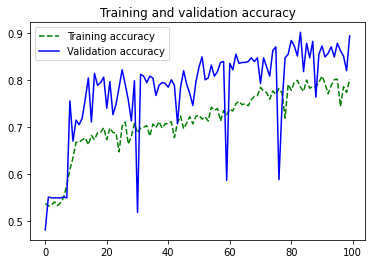

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history4)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model_4acc.png'))

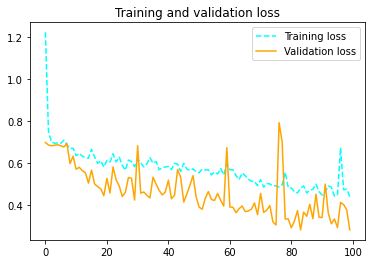

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history4)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model4_loss.png'))

In [ ]:
print_opt_results(history4)

Epoch [end]: 100
Epoch [opt]: 84
Valid accuracy [end]: 0.8945
Valid accuracy [opt]: 0.9023
Valid loss [end]: 0.2804
Valid loss [opt]: 0.2808


In [ ]:
test_model(model4)

10/10 [==============================] - 0s 25ms/step - loss: 0.2999 - acc: 0.8906

---------------------------------
Accuracy: 89.06 %
Loss: 29.99 %
---------------------------------



## Model 4.1
Model 2 more complex (more node in dense layer)

In [ ]:
model41 = models.Sequential()
model41.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model41.add(layers.MaxPooling2D((2, 2)))
model41.add(layers.Conv2D(64, (3, 3), activation='relu'))
model41.add(layers.MaxPooling2D((2, 2)))
model41.add(layers.Conv2D(128, (3, 3), activation='relu'))
model41.add(layers.MaxPooling2D((2, 2)))
model41.add(layers.Conv2D(128, (3, 3), activation='relu'))
model41.add(layers.Flatten())
model41.add(layers.Dense(128, activation="relu"))
model41.add(layers.Dropout(0.2))
model41.add(layers.Dense(1, activation='sigmoid'))

model41.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model41.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history41 = model41.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 7s 96ms/step - loss: 0.8610 - acc: 0.5285 - val_loss: 0.6898 - val_acc: 0.5762
Epoch 2/100
66/66 [==============================] - 6s 90ms/step - loss: 0.6988 - acc: 0.5332 - val_loss: 0.6820 - val_acc: 0.5801
Epoch 3/100
66/66 [==============================] - 6s 90ms/step - loss: 0.7479 - acc: 0.5209 - val_loss: 0.6875 - val_acc: 0.5254
Epoch 4/100
66/66 [==============================] - 6s 90ms/step - loss: 0.6907 - acc: 0.5389 - val_loss: 0.6875 - val_acc: 0.5801
Epoch 5/100
66/66 [==============================] - 6s 90ms/step - loss: 0.6946 - acc: 0.5356 - val_loss: 0.6801 - val_acc: 0.5820
Epoch 6/100
66/66 [==============================] - 6s 89ms/step - loss: 0.6932 - acc: 0.5370 - val_loss: 0.6771 - val_acc: 0.5801
Epoch 7/100
66/66 [==============================] - 6s 91ms/step - loss: 0.6916 - acc: 0.5294 - val_loss: 0.6893 - val_acc: 0.5801
Epoch 8/100
66/66 [==============================] - 6s 93ms/step - loss: 0.

In [ ]:
model41.save(os.path.join(MODEL_PATH,'calcmasses_model41.h5'))

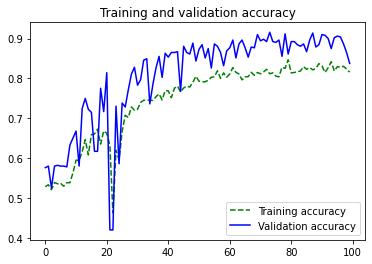

In [ ]:
plt_a = plot_acc(history41)
plt_a.show()
#plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model_4acc.png'))

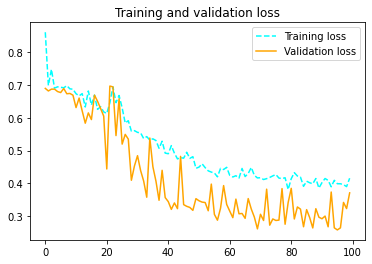

In [ ]:
plt_l = plot_loss(history41)
plt_l.show()
#plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model4_loss.png'))

In [ ]:
print_opt_results(history41)

Epoch [end]: 100
Epoch [opt]: 74
Valid accuracy [end]: 0.8379
Valid accuracy [opt]: 0.9160
Valid loss [end]: 0.3712
Valid loss [opt]: 0.2728


In [ ]:
test_model(model41)

10/10 [==============================] - 0s 28ms/step - loss: 0.4127 - acc: 0.7937

---------------------------------
Accuracy: 79.37 %
Loss: 41.27 %
---------------------------------



## Model 5
Model 2 with larger batch size

In [ ]:
BATCH_SIZE = 64

###Model 5.1 dense 64

In [ ]:
model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model5.add(layers.Flatten())
model5.add(layers.Dense(64, activation="relu"))
model5.add(layers.Dropout(0.2))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_12 (Flatten)        (None, 147968)          

In [ ]:
history5 = model5.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 8s 181ms/step - loss: 0.8181 - acc: 0.5183 - val_loss: 0.6908 - val_acc: 0.5488
Epoch 2/100
33/33 [==============================] - 6s 176ms/step - loss: 0.7012 - acc: 0.5453 - val_loss: 0.6897 - val_acc: 0.5488
Epoch 3/100
33/33 [==============================] - 6s 174ms/step - loss: 0.7015 - acc: 0.5434 - val_loss: 0.6814 - val_acc: 0.5488
Epoch 4/100
33/33 [==============================] - 6s 175ms/step - loss: 0.6877 - acc: 0.5361 - val_loss: 0.6868 - val_acc: 0.5469
Epoch 5/100
33/33 [==============================] - 6s 176ms/step - loss: 0.6943 - acc: 0.5453 - val_loss: 0.6826 - val_acc: 0.5488
Epoch 6/100
33/33 [==============================] - 6s 175ms/step - loss: 0.7065 - acc: 0.5419 - val_loss: 0.6850 - val_acc: 0.5488
Epoch 7/100
33/33 [==============================] - 6s 174ms/step - loss: 0.6925 - acc: 0.5294 - val_loss: 0.6819 - val_acc: 0.5488
Epoch 8/100
33/33 [==============================] - 6s 176ms/step - 

In [ ]:
model5.save(os.path.join(MODEL_PATH,'calcmasses_model5.h5'))

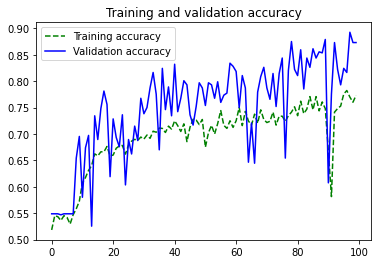

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history5)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model5_acc.png'))

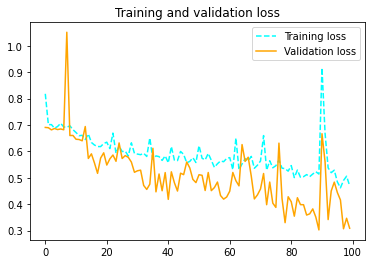

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history5)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model5_loss.png'))

In [ ]:
print_opt_results(history5)

Epoch [end]: 100
Epoch [opt]: 98
Valid accuracy [end]: 0.8730
Valid accuracy [opt]: 0.8926
Valid loss [end]: 0.3087
Valid loss [opt]: 0.3067


In [ ]:
test_model(model5)

5/5 [==============================] - 0s 39ms/step - loss: 0.3403 - acc: 0.8500

---------------------------------
Accuracy: 85.00 %
Loss: 34.03 %
---------------------------------



###Model 5.2 dense 128

In [ ]:
model52 = models.Sequential()
model52.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model52.add(layers.MaxPooling2D((2, 2)))
model52.add(layers.Conv2D(64, (3, 3), activation='relu'))
model52.add(layers.MaxPooling2D((2, 2)))
model52.add(layers.Conv2D(128, (3, 3), activation='relu'))
model52.add(layers.Flatten())
model52.add(layers.Dense(128, activation="relu"))
model52.add(layers.Dropout(0.2))
model52.add(layers.Dense(1, activation='sigmoid'))

model52.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_12 (Flatten)        (None, 147968)          

In [ ]:
history52 = model52.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 7s 188ms/step - loss: 0.9897 - acc: 0.4947 - val_loss: 0.6909 - val_acc: 0.5488
Epoch 2/100
33/33 [==============================] - 6s 183ms/step - loss: 0.7016 - acc: 0.5178 - val_loss: 0.7646 - val_acc: 0.4551
Epoch 3/100
33/33 [==============================] - 6s 187ms/step - loss: 0.7137 - acc: 0.5381 - val_loss: 0.6892 - val_acc: 0.5488
Epoch 4/100
33/33 [==============================] - 6s 185ms/step - loss: 0.6926 - acc: 0.5217 - val_loss: 0.6852 - val_acc: 0.5508
Epoch 5/100
33/33 [==============================] - 6s 184ms/step - loss: 0.6975 - acc: 0.5236 - val_loss: 0.6804 - val_acc: 0.5488
Epoch 6/100
33/33 [==============================] - 6s 185ms/step - loss: 0.6922 - acc: 0.5352 - val_loss: 0.6902 - val_acc: 0.5488
Epoch 7/100
33/33 [==============================] - 6s 185ms/step - loss: 0.6927 - acc: 0.5381 - val_loss: 0.6886 - val_acc: 0.5488
Epoch 8/100
33/33 [==============================] - 6s 188ms/step - 

In [ ]:
model52.save(os.path.join(MODEL_PATH,'calcmasses_model52.h5'))

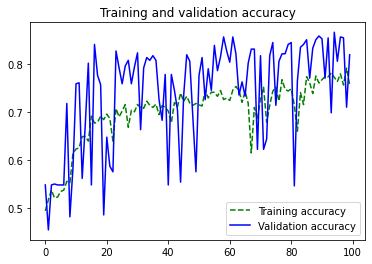

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history52)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model52_acc.png'))

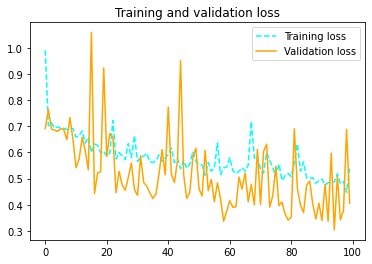

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history52)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model52_loss.png'))

In [ ]:
print_opt_results(history52)

Epoch [end]: 100
Epoch [opt]: 95
Valid accuracy [end]: 0.8203
Valid accuracy [opt]: 0.8672
Valid loss [end]: 0.4063
Valid loss [opt]: 0.3041


In [ ]:
test_model(model52)

5/5 [==============================] - 0s 40ms/step - loss: 0.4965 - acc: 0.7656

---------------------------------
Accuracy: 76.56 %
Loss: 49.65 %
---------------------------------



## Model 6
Model 2 with smaller batch size

In [ ]:
BATCH_SIZE = 20

###Model 6.1 dense 64

In [ ]:
model6 = models.Sequential()
model6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model6.add(layers.Flatten())
model6.add(layers.Dense(64, activation="relu"))
model6.add(layers.Dropout(0.2))
model6.add(layers.Dense(1, activation='sigmoid'))

model6.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_13 (Flatten)        (None, 147968)          

In [ ]:
history6 = model6.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
107/107 [==============================] - 10s 74ms/step - loss: 0.8702 - acc: 0.4935 - val_loss: 0.6876 - val_acc: 0.5462
Epoch 2/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6977 - acc: 0.5332 - val_loss: 0.6857 - val_acc: 0.5462
Epoch 3/100
107/107 [==============================] - 7s 70ms/step - loss: 0.7069 - acc: 0.5346 - val_loss: 0.6906 - val_acc: 0.5462
Epoch 4/100
107/107 [==============================] - 7s 68ms/step - loss: 0.6949 - acc: 0.5290 - val_loss: 0.6814 - val_acc: 0.5481
Epoch 5/100
107/107 [==============================] - 7s 69ms/step - loss: 0.7138 - acc: 0.5360 - val_loss: 0.6766 - val_acc: 0.5423
Epoch 6/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6954 - acc: 0.6009 - val_loss: 0.6439 - val_acc: 0.6923
Epoch 7/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6653 - acc: 0.6355 - val_loss: 0.5828 - val_acc: 0.7173
Epoch 8/100
107/107 [==============================] - 7s 69m

In [ ]:
model6.save(os.path.join(MODEL_PATH,'calcmasses_model6.h5'))

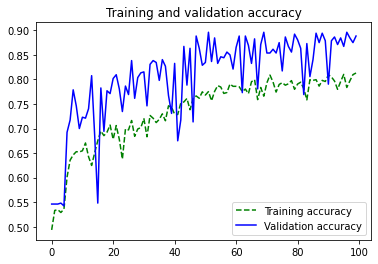

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history6)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model6_acc.png'))

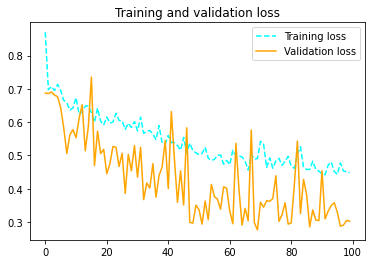

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history6)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model6_loss.png'))

In [ ]:
print_opt_results(history6)

Epoch [end]: 100
Epoch [opt]: 52
Valid accuracy [end]: 0.8885
Valid accuracy [opt]: 0.8962
Valid loss [end]: 0.3022
Valid loss [opt]: 0.2936


In [ ]:
test_model(model6)

16/16 [==============================] - 0s 19ms/step - loss: 0.3702 - acc: 0.8562

---------------------------------
Accuracy: 85.62 %
Loss: 37.02 %
---------------------------------



###Model 6.2 dense 128

In [ ]:
model62 = models.Sequential()
model62.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model62.add(layers.MaxPooling2D((2, 2)))
model62.add(layers.Conv2D(64, (3, 3), activation='relu'))
model62.add(layers.MaxPooling2D((2, 2)))
model62.add(layers.Conv2D(128, (3, 3), activation='relu'))
model62.add(layers.Flatten())
model62.add(layers.Dense(128, activation="relu"))
model62.add(layers.Dropout(0.2))
model62.add(layers.Dense(1, activation='sigmoid'))

model62.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model62.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_16 (Flatten)        (None, 147968)          

In [ ]:
history62 = model62.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
107/107 [==============================] - 9s 78ms/step - loss: 0.9362 - acc: 0.5201 - val_loss: 0.6883 - val_acc: 0.5462
Epoch 2/100
107/107 [==============================] - 8s 73ms/step - loss: 0.7022 - acc: 0.5257 - val_loss: 0.7349 - val_acc: 0.5462
Epoch 3/100
107/107 [==============================] - 8s 73ms/step - loss: 0.7017 - acc: 0.5266 - val_loss: 0.6801 - val_acc: 0.5462
Epoch 4/100
107/107 [==============================] - 8s 73ms/step - loss: 0.6981 - acc: 0.5481 - val_loss: 0.6847 - val_acc: 0.5096
Epoch 5/100
107/107 [==============================] - 8s 73ms/step - loss: 0.6962 - acc: 0.5537 - val_loss: 0.6738 - val_acc: 0.5923
Epoch 6/100
107/107 [==============================] - 8s 73ms/step - loss: 0.6691 - acc: 0.6117 - val_loss: 0.6065 - val_acc: 0.7385
Epoch 7/100
107/107 [==============================] - 8s 73ms/step - loss: 0.6622 - acc: 0.6168 - val_loss: 0.5685 - val_acc: 0.7615
Epoch 8/100
107/107 [==============================] - 8s 73ms

In [ ]:
model62.save(os.path.join(MODEL_PATH,'calcmasses_model62.h5'))

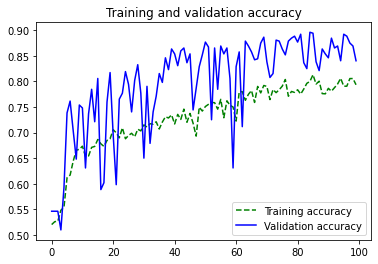

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history62)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model62_acc.png'))

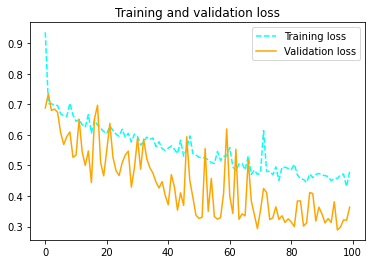

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history62)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model62_loss.png'))

In [ ]:
print_opt_results(history62)

Epoch [end]: 100
Epoch [opt]: 85
Valid accuracy [end]: 0.8404
Valid accuracy [opt]: 0.8962
Valid loss [end]: 0.3634
Valid loss [opt]: 0.3013


In [ ]:
test_model(model62)

16/16 [==============================] - 0s 18ms/step - loss: 0.4183 - acc: 0.8062

---------------------------------
Accuracy: 80.62 %
Loss: 41.83 %
---------------------------------



## Model 7
Model 6 with different learning rate :

1.   lr=0.00001
2.   lr=0.0001
3.   lr=0.01



In [ ]:
BATCH_SIZE=20;

### Model 7.1 OLD

In [ ]:
model71 = models.Sequential()
model71.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model71.add(layers.MaxPooling2D((2, 2)))
model71.add(layers.Conv2D(64, (3, 3), activation='relu'))
model71.add(layers.MaxPooling2D((2, 2)))
model71.add(layers.Conv2D(128, (3, 3), activation='relu'))
model71.add(layers.Flatten())
model71.add(layers.Dense(64, activation="relu"))
model71.add(layers.Dropout(0.2))
model71.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model71.compile(optimizer=optimizers.RMSprop(learning_rate=0.00001), loss="binary_crossentropy", metrics=['acc'])

model71.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_17 (Flatten)        (None, 147968)          

In [ ]:
history71 = model71.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
107/107 [==============================] - 9s 71ms/step - loss: 0.6953 - acc: 0.5224 - val_loss: 0.6893 - val_acc: 0.5462
Epoch 2/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6916 - acc: 0.5444 - val_loss: 0.6879 - val_acc: 0.5462
Epoch 3/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6890 - acc: 0.5561 - val_loss: 0.6846 - val_acc: 0.5462
Epoch 4/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6875 - acc: 0.5561 - val_loss: 0.6816 - val_acc: 0.5635
Epoch 5/100
107/107 [==============================] - 7s 70ms/step - loss: 0.6859 - acc: 0.5579 - val_loss: 0.6795 - val_acc: 0.7635
Epoch 6/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6818 - acc: 0.5687 - val_loss: 0.6699 - val_acc: 0.5654
Epoch 7/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6784 - acc: 0.5706 - val_loss: 0.6628 - val_acc: 0.6365
Epoch 8/100
107/107 [==============================] - 7s 69ms

In [ ]:
model71.save(os.path.join(MODEL_PATH,'calcmasses_model7_1.h5'))

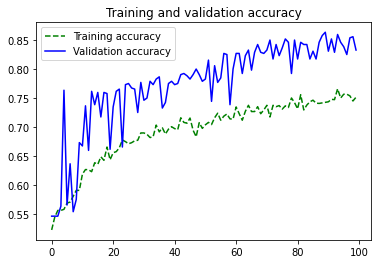

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history71)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_1_acc.png'))

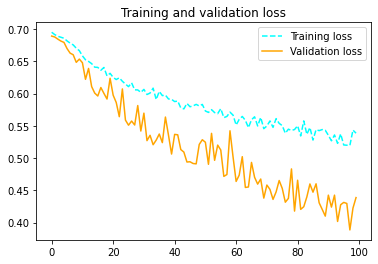

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history71)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_1_loss.png'))

In [ ]:
print_opt_results(history71)

Epoch [end]: 100
Epoch [opt]: 90
Valid accuracy [end]: 0.8327
Valid accuracy [opt]: 0.8635
Valid loss [end]: 0.4387
Valid loss [opt]: 0.4099


In [ ]:
test_model(model71)

16/16 [==============================] - 0s 18ms/step - loss: 0.4929 - acc: 0.7875

---------------------------------
Accuracy: 78.75 %
Loss: 49.29 %
---------------------------------



### Model 7.2 OLD

In [ ]:
model72 = models.Sequential()
model72.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model72.add(layers.MaxPooling2D((2, 2)))
model72.add(layers.Conv2D(64, (3, 3), activation='relu'))
model72.add(layers.MaxPooling2D((2, 2)))
model72.add(layers.Conv2D(128, (3, 3), activation='relu'))
model72.add(layers.Flatten())
model72.add(layers.Dense(64, activation="relu"))
model72.add(layers.Dropout(0.2))
model72.add(layers.Dense(1, activation='sigmoid'))

model72.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=0.0001),
              metrics=['acc'])

model72.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_18 (Flatten)        (None, 147968)          

In [ ]:
history72 = model72.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
107/107 [==============================] - 9s 71ms/step - loss: 0.6968 - acc: 0.5243 - val_loss: 0.6929 - val_acc: 0.4635
Epoch 2/100
107/107 [==============================] - 8s 71ms/step - loss: 0.6946 - acc: 0.5407 - val_loss: 0.6867 - val_acc: 0.5462
Epoch 3/100
107/107 [==============================] - 8s 71ms/step - loss: 0.6873 - acc: 0.5528 - val_loss: 0.6727 - val_acc: 0.7442
Epoch 4/100
107/107 [==============================] - 8s 70ms/step - loss: 0.6767 - acc: 0.5944 - val_loss: 0.6409 - val_acc: 0.5942
Epoch 5/100
107/107 [==============================] - 8s 71ms/step - loss: 0.6660 - acc: 0.6126 - val_loss: 0.6157 - val_acc: 0.7904
Epoch 6/100
107/107 [==============================] - 8s 70ms/step - loss: 0.6486 - acc: 0.6322 - val_loss: 0.6211 - val_acc: 0.6846
Epoch 7/100
107/107 [==============================] - 8s 70ms/step - loss: 0.6215 - acc: 0.6621 - val_loss: 0.5524 - val_acc: 0.7904
Epoch 8/100
107/107 [==============================] - 8s 71ms

In [ ]:
model72.save(os.path.join(MODEL_PATH,'calcmasses_model7_2.h5'))

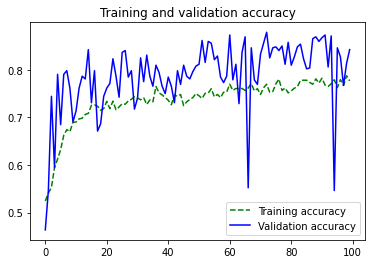

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history72)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_2_acc.png'))

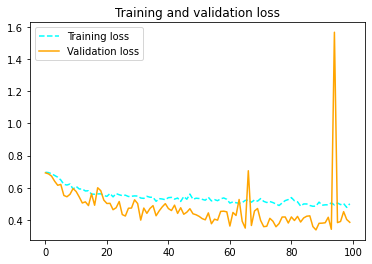

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history72)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_2_loss.png'))

In [ ]:
print_opt_results(history72)

Epoch [end]: 100
Epoch [opt]: 73
Valid accuracy [end]: 0.8423
Valid accuracy [opt]: 0.8788
Valid loss [end]: 0.3856
Valid loss [opt]: 0.3608


In [ ]:
test_model(model72)

16/16 [==============================] - 0s 19ms/step - loss: 0.4179 - acc: 0.8000

---------------------------------
Accuracy: 80.00 %
Loss: 41.79 %
---------------------------------



### Model 7.3 OLD

In [ ]:
model73 = models.Sequential()
model73.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model73.add(layers.MaxPooling2D((2, 2)))
model73.add(layers.Conv2D(64, (3, 3), activation='relu'))
model73.add(layers.MaxPooling2D((2, 2)))
model73.add(layers.Conv2D(128, (3, 3), activation='relu'))
model73.add(layers.Flatten())
model73.add(layers.Dense(64, activation="relu"))
model73.add(layers.Dropout(0.2))
model73.add(layers.Dense(1, activation='sigmoid'))


model73.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=0.01),
              metrics=['acc'])

model73.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_19 (Flatten)        (None, 147968)          

In [ ]:
history73 = model73.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
107/107 [==============================] - 9s 72ms/step - loss: 41.8333 - acc: 0.5308 - val_loss: 0.6890 - val_acc: 0.5462
Epoch 2/100
107/107 [==============================] - 7s 67ms/step - loss: 0.6898 - acc: 0.5439 - val_loss: 0.6890 - val_acc: 0.5462
Epoch 3/100
107/107 [==============================] - 7s 66ms/step - loss: 0.6898 - acc: 0.5439 - val_loss: 0.6889 - val_acc: 0.5462
Epoch 4/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6899 - acc: 0.5439 - val_loss: 0.6889 - val_acc: 0.5462
Epoch 5/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6898 - acc: 0.5439 - val_loss: 0.6889 - val_acc: 0.5462
Epoch 6/100
107/107 [==============================] - 7s 70ms/step - loss: 0.6897 - acc: 0.5439 - val_loss: 0.6889 - val_acc: 0.5462
Epoch 7/100
107/107 [==============================] - 7s 69ms/step - loss: 0.6899 - acc: 0.5439 - val_loss: 0.6889 - val_acc: 0.5462
Epoch 8/100
107/107 [==============================] - 7s 68m

In [ ]:
model73.save(os.path.join(MODEL_PATH,'calcmasses_model7_3.h5'))

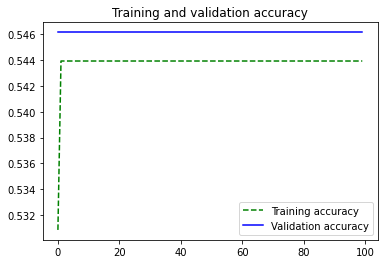

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history73)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_3_acc.png'))

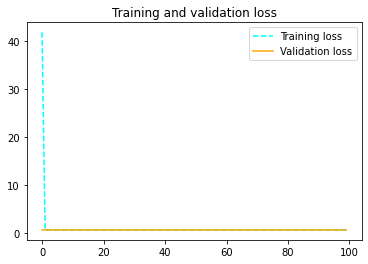

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history73)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_3_loss.png'))

In [ ]:
print_opt_results(history73)

Epoch [end]: 100
Epoch [opt]: 1
Valid accuracy [end]: 0.5462
Valid accuracy [opt]: 0.5462
Valid loss [end]: 0.6889
Valid loss [opt]: 0.6890


In [ ]:
test_model(model73)

16/16 [==============================] - 0s 18ms/step - loss: 0.7039 - acc: 0.4719

---------------------------------
Accuracy: 47.19 %
Loss: 70.39 %
---------------------------------



In [ ]:
BATCH_SIZE=32;

### Model 7.1

In [ ]:
model74 = models.Sequential()
model74.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model74.add(layers.MaxPooling2D((2, 2)))
model74.add(layers.Conv2D(64, (3, 3), activation='relu'))
model74.add(layers.MaxPooling2D((2, 2)))
model74.add(layers.Conv2D(128, (3, 3), activation='relu'))
model74.add(layers.Flatten())
model74.add(layers.Dense(128, activation="relu"))
model74.add(layers.Dropout(0.2))
model74.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model74.compile(optimizer=optimizers.RMSprop(learning_rate=0.00001), loss="binary_crossentropy", metrics=['acc'])

model74.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_20 (Flatten)        (None, 147968)          

In [ ]:
history74 = model74.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 103ms/step - loss: 0.6990 - acc: 0.5213 - val_loss: 0.6883 - val_acc: 0.5488
Epoch 2/100
66/66 [==============================] - 7s 104ms/step - loss: 0.6936 - acc: 0.5251 - val_loss: 0.6845 - val_acc: 0.5527
Epoch 3/100
66/66 [==============================] - 7s 99ms/step - loss: 0.6918 - acc: 0.5403 - val_loss: 0.6898 - val_acc: 0.5488
Epoch 4/100
66/66 [==============================] - 7s 101ms/step - loss: 0.6862 - acc: 0.5550 - val_loss: 0.6873 - val_acc: 0.5488
Epoch 5/100
66/66 [==============================] - 7s 101ms/step - loss: 0.6828 - acc: 0.5655 - val_loss: 0.6739 - val_acc: 0.5801
Epoch 6/100
66/66 [==============================] - 7s 102ms/step - loss: 0.6834 - acc: 0.5621 - val_loss: 0.6743 - val_acc: 0.6172
Epoch 7/100
66/66 [==============================] - 7s 103ms/step - loss: 0.6762 - acc: 0.5802 - val_loss: 0.6587 - val_acc: 0.6113
Epoch 8/100
66/66 [==============================] - 7s 107ms/step - l

In [ ]:
model74.save(os.path.join(MODEL_PATH,'calcmasses_model7_4.h5'))

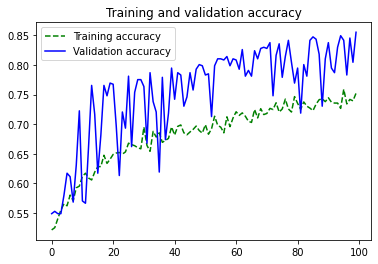

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history74)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_4_acc.png'))

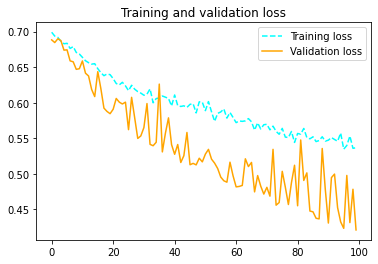

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history74)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_4_loss.png'))

In [ ]:
print_opt_results(history74)

Epoch [end]: 100
Epoch [opt]: 100
Valid accuracy [end]: 0.8555
Valid accuracy [opt]: 0.8555
Valid loss [end]: 0.4211
Valid loss [opt]: 0.4211


In [ ]:
test_model(model74)

10/10 [==============================] - 0s 28ms/step - loss: 0.4796 - acc: 0.8000

---------------------------------
Accuracy: 80.00 %
Loss: 47.96 %
---------------------------------



### Model 7.2

In [ ]:
model75 = models.Sequential()
model75.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model75.add(layers.MaxPooling2D((2, 2)))
model75.add(layers.Conv2D(64, (3, 3), activation='relu'))
model75.add(layers.MaxPooling2D((2, 2)))
model75.add(layers.Conv2D(128, (3, 3), activation='relu'))
model75.add(layers.Flatten())
model75.add(layers.Dense(128, activation="relu"))
model75.add(layers.Dropout(0.2))
model75.add(layers.Dense(1, activation='sigmoid'))

model75.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=0.0001),
              metrics=['acc'])

model75.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_21 (Flatten)        (None, 147968)          

In [ ]:
history75 = model75.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 107ms/step - loss: 0.7114 - acc: 0.5166 - val_loss: 0.7213 - val_acc: 0.5488
Epoch 2/100
66/66 [==============================] - 7s 105ms/step - loss: 0.6946 - acc: 0.5555 - val_loss: 0.6805 - val_acc: 0.6797
Epoch 3/100
66/66 [==============================] - 7s 105ms/step - loss: 0.6881 - acc: 0.5550 - val_loss: 0.6767 - val_acc: 0.6699
Epoch 4/100
66/66 [==============================] - 7s 104ms/step - loss: 0.6805 - acc: 0.5806 - val_loss: 0.6522 - val_acc: 0.6309
Epoch 5/100
66/66 [==============================] - 7s 105ms/step - loss: 0.6643 - acc: 0.6101 - val_loss: 0.6361 - val_acc: 0.5645
Epoch 6/100
66/66 [==============================] - 7s 105ms/step - loss: 0.6582 - acc: 0.6167 - val_loss: 0.5961 - val_acc: 0.7676
Epoch 7/100
66/66 [==============================] - 7s 105ms/step - loss: 0.6356 - acc: 0.6556 - val_loss: 0.5603 - val_acc: 0.7559
Epoch 8/100
66/66 [==============================] - 7s 103ms/step - 

In [ ]:
model75.save(os.path.join(MODEL_PATH,'calcmasses_model7_5.h5'))

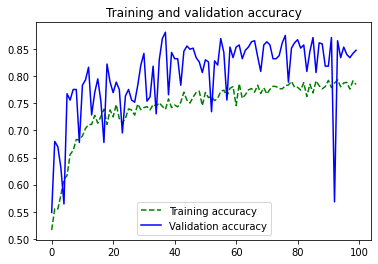

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history75)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_5_acc.png'))

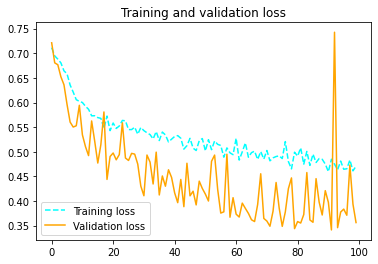

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history75)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_5_loss.png'))

In [ ]:
print_opt_results(history75)

Epoch [end]: 100
Epoch [opt]: 38
Valid accuracy [end]: 0.8477
Valid accuracy [opt]: 0.8809
Valid loss [end]: 0.3562
Valid loss [opt]: 0.4300


In [ ]:
test_model(model75)

10/10 [==============================] - 0s 25ms/step - loss: 0.4056 - acc: 0.8000

---------------------------------
Accuracy: 80.00 %
Loss: 40.56 %
---------------------------------



### Model 7.3

In [ ]:
model76 = models.Sequential()
model76.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model76.add(layers.MaxPooling2D((2, 2)))
model76.add(layers.Conv2D(64, (3, 3), activation='relu'))
model76.add(layers.MaxPooling2D((2, 2)))
model76.add(layers.Conv2D(128, (3, 3), activation='relu'))
model76.add(layers.Flatten())
model76.add(layers.Dense(128, activation="relu"))
model76.add(layers.Dropout(0.2))
model76.add(layers.Dense(1, activation='sigmoid'))


model76.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=0.01),
              metrics=['acc'])

model76.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 147968)           

In [ ]:
history76 = model76.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 17s 107ms/step - loss: 110.0804 - acc: 0.5398 - val_loss: 0.6901 - val_acc: 0.5430
Epoch 2/100
66/66 [==============================] - 6s 97ms/step - loss: 0.7430 - acc: 0.5403 - val_loss: 0.6896 - val_acc: 0.5430
Epoch 3/100
66/66 [==============================] - 6s 97ms/step - loss: 0.6895 - acc: 0.5441 - val_loss: 0.6896 - val_acc: 0.5430
Epoch 4/100
66/66 [==============================] - 6s 96ms/step - loss: 0.6893 - acc: 0.5460 - val_loss: 0.6895 - val_acc: 0.5430
Epoch 5/100
66/66 [==============================] - 6s 97ms/step - loss: 0.6895 - acc: 0.5451 - val_loss: 0.6895 - val_acc: 0.5430
Epoch 6/100
66/66 [==============================] - 6s 97ms/step - loss: 0.6898 - acc: 0.5432 - val_loss: 0.6895 - val_acc: 0.5430
Epoch 7/100
66/66 [==============================] - 6s 98ms/step - loss: 0.6900 - acc: 0.5422 - val_loss: 0.6895 - val_acc: 0.5430
Epoch 8/100
66/66 [==============================] - 6s 98ms/step - loss

In [ ]:
model76.save(os.path.join(MODEL_PATH,'calcmasses_model7_6.h5'))

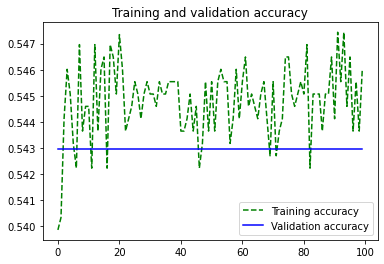

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history76)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_6_acc.png'))

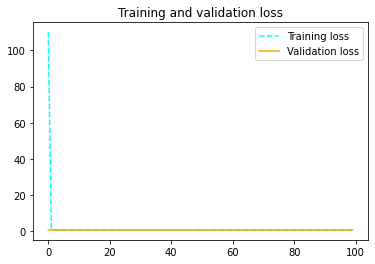

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history76)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model7_6_loss.png'))

In [ ]:
print_opt_results(history76)

Epoch [end]: 100
Epoch [opt]: 1
Valid accuracy [end]: 0.5430
Valid accuracy [opt]: 0.5430
Valid loss [end]: 0.6895
Valid loss [opt]: 0.6901


In [ ]:
test_model(model76)

10/10 [==============================] - 0s 26ms/step - loss: 0.7056 - acc: 0.4563

---------------------------------
Accuracy: 45.63 %
Loss: 70.56 %
---------------------------------



## Model 8
Model  with ADAM optimizer with:


1.   learning_rate= 0.001 (*Default*)
2.   learning_rate= 0.01
3.   learning_rate= 0.0001
4.   learning_rate= 0.00001



In [ ]:
BATCH_SIZE = 32
EPOCHS = 100

###8.1 Adam with default learning rate

In [ ]:
model81 = models.Sequential()
model81.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model81.add(layers.MaxPooling2D((2, 2)))
model81.add(layers.Conv2D(64, (3, 3), activation='relu'))
model81.add(layers.MaxPooling2D((2, 2)))
model81.add(layers.Conv2D(128, (3, 3), activation='relu'))
model81.add(layers.Flatten())
model81.add(layers.Dense(128, activation="relu"))
model81.add(layers.Dropout(0.2))
model81.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model81.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(),
              metrics=['acc'])

model81.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 flatten_2 (Flatten)         (None, 147968)           

In [ ]:
history81 = model81.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 104ms/step - loss: 0.7198 - acc: 0.5313 - val_loss: 0.6921 - val_acc: 0.5430
Epoch 2/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6900 - acc: 0.5451 - val_loss: 0.6917 - val_acc: 0.5430
Epoch 3/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6924 - acc: 0.5427 - val_loss: 0.6910 - val_acc: 0.5430
Epoch 4/100
66/66 [==============================] - 6s 92ms/step - loss: 0.6895 - acc: 0.5441 - val_loss: 0.6886 - val_acc: 0.5430
Epoch 5/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6904 - acc: 0.5451 - val_loss: 0.6891 - val_acc: 0.5430
Epoch 6/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6873 - acc: 0.5422 - val_loss: 0.6887 - val_acc: 0.5430
Epoch 7/100
66/66 [==============================] - 6s 92ms/step - loss: 0.6910 - acc: 0.5455 - val_loss: 0.6896 - val_acc: 0.5430
Epoch 8/100
66/66 [==============================] - 6s 93ms/step - loss: 0

In [ ]:
model81.save(os.path.join(MODEL_PATH,'calcmasses_model8_1.h5'))

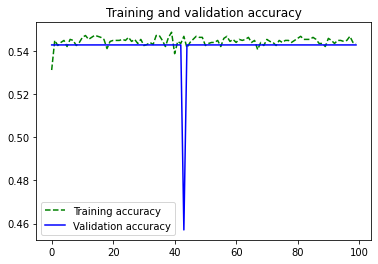

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history81)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model8_1_acc.png'))

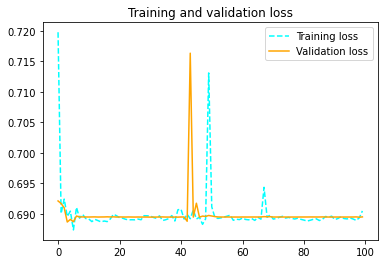

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history81)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model8_1_loss.png'))

In [ ]:
print_opt_results(history81)

Epoch [end]: 100
Epoch [opt]: 1
Valid accuracy [end]: 0.5430
Valid accuracy [opt]: 0.5430
Valid loss [end]: 0.6895
Valid loss [opt]: 0.6921


In [ ]:
test_model(model81)

10/10 [==============================] - 0s 21ms/step - loss: 0.7032 - acc: 0.4563

---------------------------------
Accuracy: 45.63 %
Loss: 70.32 %
---------------------------------



### Model 8.2 Adam with learning rate 0.01



In [ ]:
model82 = models.Sequential()
model82.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model82.add(layers.MaxPooling2D((2, 2)))
model82.add(layers.Conv2D(64, (3, 3), activation='relu'))
model82.add(layers.MaxPooling2D((2, 2)))
model82.add(layers.Conv2D(128, (3, 3), activation='relu'))
model82.add(layers.Flatten())
model82.add(layers.Dense(128, activation="relu"))
model82.add(layers.Dropout(0.2))
model82.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model82.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(lr=0.01),
              metrics=['acc'])

model82.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_3 (Flatten)         (None, 147968)           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history82 = model82.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 105ms/step - loss: 5.5919 - acc: 0.5119 - val_loss: 0.6910 - val_acc: 0.5430
Epoch 2/100
66/66 [==============================] - 7s 103ms/step - loss: 0.6902 - acc: 0.5398 - val_loss: 0.6895 - val_acc: 0.5430
Epoch 3/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6894 - acc: 0.5460 - val_loss: 0.6895 - val_acc: 0.5430
Epoch 4/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6899 - acc: 0.5451 - val_loss: 0.6896 - val_acc: 0.5430
Epoch 5/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6900 - acc: 0.5446 - val_loss: 0.6895 - val_acc: 0.5430
Epoch 6/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6898 - acc: 0.5441 - val_loss: 0.6895 - val_acc: 0.5430
Epoch 7/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6891 - acc: 0.5470 - val_loss: 0.6895 - val_acc: 0.5430
Epoch 8/100
66/66 [==============================] - 6s 93ms/step - loss: 

In [ ]:
model82.save(os.path.join(MODEL_PATH,'calcmasses_model8_2.h5'))

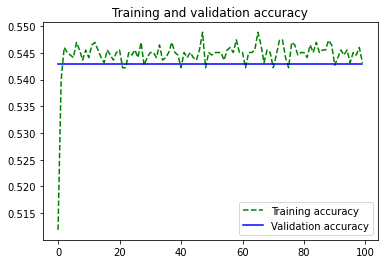

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history82)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model8_2_acc.png'))

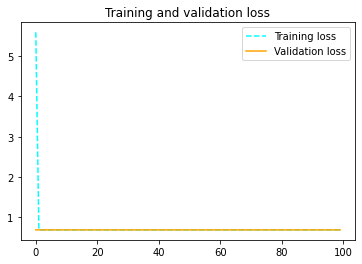

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history82)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model8_2_loss.png'))

In [ ]:
print_opt_results(history82)

Epoch [end]: 100
Epoch [opt]: 1
Valid accuracy [end]: 0.5430
Valid accuracy [opt]: 0.5430
Valid loss [end]: 0.6895
Valid loss [opt]: 0.6910


In [ ]:
test_model(model82)

10/10 [==============================] - 0s 21ms/step - loss: 0.7032 - acc: 0.4563

---------------------------------
Accuracy: 45.63 %
Loss: 70.32 %
---------------------------------



### Model 8.3 Adam with learning rate 0.0001

In [ ]:
model83 = models.Sequential()
model83.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model83.add(layers.MaxPooling2D((2, 2)))
model83.add(layers.Conv2D(64, (3, 3), activation='relu'))
model83.add(layers.MaxPooling2D((2, 2)))
model83.add(layers.Conv2D(128, (3, 3), activation='relu'))
model83.add(layers.Flatten())
model83.add(layers.Dense(128, activation="relu"))
model83.add(layers.Dropout(0.2))
model83.add(layers.Dense(1, activation='sigmoid'))

model83.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

model83.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_4 (Flatten)         (None, 147968)           

In [ ]:
history83 = model83.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 7s 98ms/step - loss: 0.7035 - acc: 0.5199 - val_loss: 0.6902 - val_acc: 0.5430
Epoch 2/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6990 - acc: 0.5119 - val_loss: 0.6933 - val_acc: 0.4531
Epoch 3/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6911 - acc: 0.5365 - val_loss: 0.6906 - val_acc: 0.5430
Epoch 4/100
66/66 [==============================] - 6s 94ms/step - loss: 0.6875 - acc: 0.5455 - val_loss: 0.6863 - val_acc: 0.5430
Epoch 5/100
66/66 [==============================] - 6s 94ms/step - loss: 0.6859 - acc: 0.5398 - val_loss: 0.6868 - val_acc: 0.5430
Epoch 6/100
66/66 [==============================] - 6s 92ms/step - loss: 0.6845 - acc: 0.5560 - val_loss: 0.6933 - val_acc: 0.4648
Epoch 7/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6828 - acc: 0.5455 - val_loss: 0.6788 - val_acc: 0.5723
Epoch 8/100
66/66 [==============================] - 6s 94ms/step - loss: 0.

In [ ]:
model83.save(os.path.join(MODEL_PATH,'calcmasses_model8_3.h5'))

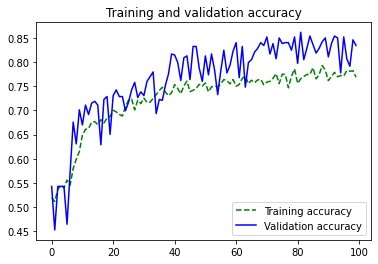

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history83)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model8_3_acc.png'))

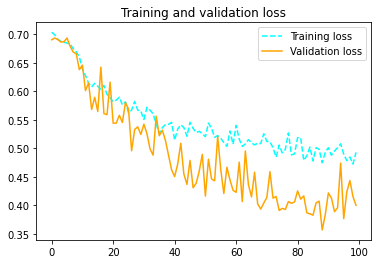

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history83)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model8_3_loss.png'))

In [ ]:
print_opt_results(history83)

Epoch [end]: 100
Epoch [opt]: 82
Valid accuracy [end]: 0.8340
Valid accuracy [opt]: 0.8613
Valid loss [end]: 0.4000
Valid loss [opt]: 0.4108


In [ ]:
test_model(model83)

10/10 [==============================] - 0s 27ms/step - loss: 0.4462 - acc: 0.8000

---------------------------------
Accuracy: 80.00 %
Loss: 44.62 %
---------------------------------



### Model 8.4 Adam with learning rate 0.00001

In [ ]:
model84 = models.Sequential()
model84.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model84.add(layers.MaxPooling2D((2, 2)))
model84.add(layers.Conv2D(64, (3, 3), activation='relu'))
model84.add(layers.MaxPooling2D((2, 2)))
model84.add(layers.Conv2D(128, (3, 3), activation='relu'))
model84.add(layers.Flatten())
model84.add(layers.Dense(128, activation="relu"))
model84.add(layers.Dropout(0.2))
model84.add(layers.Dense(1, activation='sigmoid'))


model84.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(lr=0.00001),
              metrics=['acc'])

model84.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_5 (Flatten)         (None, 147968)           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history84 = model84.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 7s 98ms/step - loss: 0.6941 - acc: 0.5256 - val_loss: 0.6888 - val_acc: 0.5430
Epoch 2/100
66/66 [==============================] - 7s 103ms/step - loss: 0.6926 - acc: 0.5356 - val_loss: 0.6875 - val_acc: 0.5449
Epoch 3/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6900 - acc: 0.5460 - val_loss: 0.6869 - val_acc: 0.5430
Epoch 4/100
66/66 [==============================] - 6s 94ms/step - loss: 0.6909 - acc: 0.5389 - val_loss: 0.6824 - val_acc: 0.5449
Epoch 5/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6828 - acc: 0.5678 - val_loss: 0.6959 - val_acc: 0.5430
Epoch 6/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6795 - acc: 0.5787 - val_loss: 0.6658 - val_acc: 0.5938
Epoch 7/100
66/66 [==============================] - 6s 96ms/step - loss: 0.6699 - acc: 0.5935 - val_loss: 0.6566 - val_acc: 0.5918
Epoch 8/100
66/66 [==============================] - 7s 102ms/step - loss: 

In [ ]:
model84.save(os.path.join(MODEL_PATH,'calcmasses_model8_4.h5'))

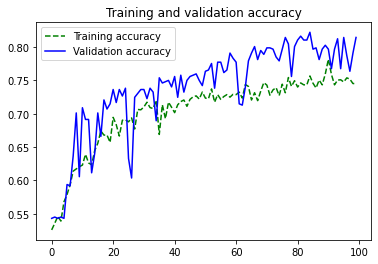

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history84)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model8_4_acc.png'))

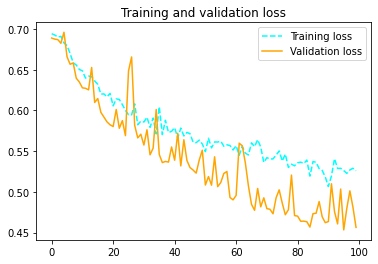

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history84)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model8_4_loss.png'))

In [ ]:
print_opt_results(history84)

Epoch [end]: 100
Epoch [opt]: 85
Valid accuracy [end]: 0.8145
Valid accuracy [opt]: 0.8223
Valid loss [end]: 0.4564
Valid loss [opt]: 0.4568


In [ ]:
test_model(model84)

10/10 [==============================] - 0s 21ms/step - loss: 0.4913 - acc: 0.7906

---------------------------------
Accuracy: 79.06 %
Loss: 49.13 %
---------------------------------



## Model 9
Model 4 with more epochs:


*   150
*   250



###Model 9.1 150 epochs

In [ ]:
EPOCHS = 150
BATCH_SIZE = 32

In [ ]:
model91 = models.Sequential()
model91.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model91.add(layers.MaxPooling2D((2, 2)))
model91.add(layers.Conv2D(64, (3, 3), activation='relu'))
model91.add(layers.MaxPooling2D((2, 2)))
model91.add(layers.Conv2D(128, (3, 3), activation='relu'))
model91.add(layers.Flatten())
model91.add(layers.Dense(128, activation="relu"))
model91.add(layers.Dropout(0.2))
model91.add(layers.Dense(1, activation='sigmoid'))

model91.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model91.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_6 (Flatten)         (None, 147968)           

In [ ]:
history91 = model91.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/150
66/66 [==============================] - 8s 102ms/step - loss: 0.8997 - acc: 0.5308 - val_loss: 0.6927 - val_acc: 0.5430
Epoch 2/150
66/66 [==============================] - 7s 102ms/step - loss: 0.7049 - acc: 0.5133 - val_loss: 0.6941 - val_acc: 0.5879
Epoch 3/150
66/66 [==============================] - 6s 94ms/step - loss: 0.6978 - acc: 0.5389 - val_loss: 0.6900 - val_acc: 0.5430
Epoch 4/150
66/66 [==============================] - 6s 94ms/step - loss: 0.6912 - acc: 0.5342 - val_loss: 0.6888 - val_acc: 0.5430
Epoch 5/150
66/66 [==============================] - 6s 95ms/step - loss: 0.7046 - acc: 0.5375 - val_loss: 0.6897 - val_acc: 0.5430
Epoch 6/150
66/66 [==============================] - 6s 96ms/step - loss: 0.6884 - acc: 0.5460 - val_loss: 0.6946 - val_acc: 0.5410
Epoch 7/150
66/66 [==============================] - 6s 95ms/step - loss: 0.6922 - acc: 0.5427 - val_loss: 0.6755 - val_acc: 0.6758
Epoch 8/150
66/66 [==============================] - 6s 94ms/step - loss: 

In [ ]:
model91.save(os.path.join(MODEL_PATH,'calcmasses_model91.h5'))

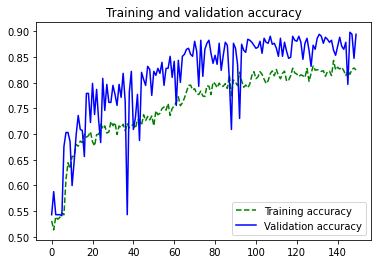

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history91)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model_91acc.png'))

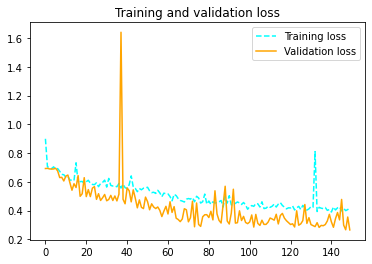

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history91)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model91_loss.png'))

In [ ]:
print_opt_results(history91)

Epoch [end]: 150
Epoch [opt]: 147
Valid accuracy [end]: 0.8945
Valid accuracy [opt]: 0.8984
Valid loss [end]: 0.2654
Valid loss [opt]: 0.2989


In [ ]:
test_model(model91)

10/10 [==============================] - 0s 19ms/step - loss: 0.3248 - acc: 0.8719

---------------------------------
Accuracy: 87.19 %
Loss: 32.48 %
---------------------------------



###Model 9.2 250 epochs

In [ ]:
EPOCHS = 250
BATCH_SIZE = 32

In [ ]:
model92 = models.Sequential()
model92.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model92.add(layers.MaxPooling2D((2, 2)))
model92.add(layers.Conv2D(64, (3, 3), activation='relu'))
model92.add(layers.MaxPooling2D((2, 2)))
model92.add(layers.Conv2D(128, (3, 3), activation='relu'))
model92.add(layers.Flatten())
model92.add(layers.Dense(128, activation="relu"))
model92.add(layers.Dropout(0.2))
model92.add(layers.Dense(1, activation='sigmoid'))

model92.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model92.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_7 (Flatten)         (None, 147968)           

In [ ]:
history92 = model92.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/250
66/66 [==============================] - 7s 98ms/step - loss: 1.1220 - acc: 0.5375 - val_loss: 0.6926 - val_acc: 0.5430
Epoch 2/250
66/66 [==============================] - 6s 96ms/step - loss: 0.6984 - acc: 0.5256 - val_loss: 0.6904 - val_acc: 0.5430
Epoch 3/250
66/66 [==============================] - 7s 101ms/step - loss: 0.7056 - acc: 0.5389 - val_loss: 0.6888 - val_acc: 0.5703
Epoch 4/250
66/66 [==============================] - 7s 100ms/step - loss: 0.7047 - acc: 0.5455 - val_loss: 0.6905 - val_acc: 0.5410
Epoch 5/250
66/66 [==============================] - 7s 100ms/step - loss: 0.6948 - acc: 0.5336 - val_loss: 0.6928 - val_acc: 0.5625
Epoch 6/250
66/66 [==============================] - 6s 96ms/step - loss: 0.7084 - acc: 0.5527 - val_loss: 0.6892 - val_acc: 0.5430
Epoch 7/250
66/66 [==============================] - 6s 95ms/step - loss: 0.6901 - acc: 0.5574 - val_loss: 0.6794 - val_acc: 0.5332
Epoch 8/250
66/66 [==============================] - 6s 94ms/step - loss:

In [ ]:
model92.save(os.path.join(MODEL_PATH,'calcmasses_model92.h5'))

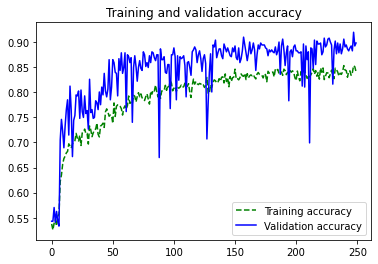

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history92)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model_92acc.png'))

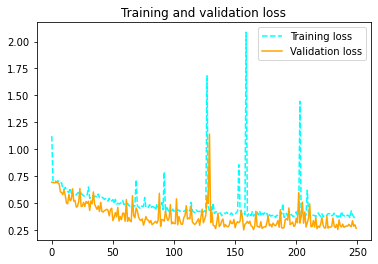

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history92)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model92_loss.png'))

In [ ]:
print_opt_results(history92)

Epoch [end]: 250
Epoch [opt]: 248
Valid accuracy [end]: 0.8984
Valid accuracy [opt]: 0.9199
Valid loss [end]: 0.2661
Valid loss [opt]: 0.2860


In [ ]:
test_model(model92)

10/10 [==============================] - 0s 20ms/step - loss: 0.3479 - acc: 0.8656

---------------------------------
Accuracy: 86.56 %
Loss: 34.79 %
---------------------------------



## Model 10
Model 4 with regularizers l2

In [ ]:
model10 = models.Sequential()
model10.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(0.001)))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model10.add(layers.Flatten())
model10.add(layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model10.add(layers.Dropout(0.2))
model10.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

model10.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['acc'])

model10.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_6 (Flatten)         (None, 147968)           

In [ ]:
history10 = model10.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 8s 105ms/step - loss: 0.8914 - acc: 0.5266 - val_loss: 0.7209 - val_acc: 0.5801
Epoch 2/100
66/66 [==============================] - 6s 97ms/step - loss: 0.7157 - acc: 0.5351 - val_loss: 0.7078 - val_acc: 0.5801
Epoch 3/100
66/66 [==============================] - 7s 98ms/step - loss: 0.7019 - acc: 0.5323 - val_loss: 0.6940 - val_acc: 0.5801
Epoch 4/100
66/66 [==============================] - 6s 98ms/step - loss: 0.6975 - acc: 0.5356 - val_loss: 0.6895 - val_acc: 0.5801
Epoch 5/100
66/66 [==============================] - 6s 97ms/step - loss: 0.6933 - acc: 0.5361 - val_loss: 0.6935 - val_acc: 0.5703
Epoch 6/100
66/66 [==============================] - 7s 98ms/step - loss: 0.6851 - acc: 0.5712 - val_loss: 0.6794 - val_acc: 0.6777
Epoch 7/100
66/66 [==============================] - 6s 97ms/step - loss: 0.6785 - acc: 0.6205 - val_loss: 0.7034 - val_acc: 0.5078
Epoch 8/100
66/66 [==============================] - 6s 97ms/step - loss: 0

In [ ]:
model10.save(os.path.join(MODEL_PATH,'calcmasses_model10.h5'))

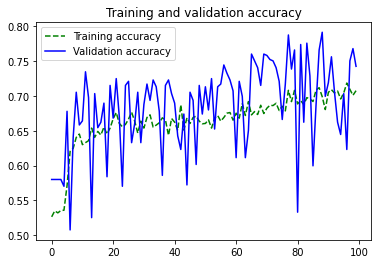

In [ ]:
plt_a = plot_acc(history10)
plt_a.show()
#plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model_4acc.png'))

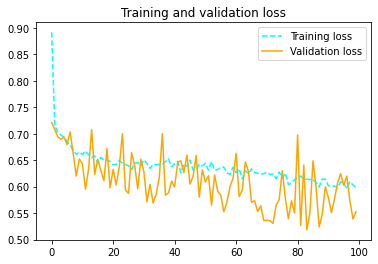

In [ ]:
plt_l = plot_loss(history10)
plt_l.show()
#plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model4_loss.png'))

In [ ]:
print_opt_results(history10)

Epoch [end]: 100
Epoch [opt]: 89
Valid accuracy [end]: 0.7422
Valid accuracy [opt]: 0.7910
Valid loss [end]: 0.5529
Valid loss [opt]: 0.5477


In [ ]:
test_model(model10)

10/10 [==============================] - 0s 25ms/step - loss: 0.5635 - acc: 0.7469

---------------------------------
Accuracy: 74.69 %
Loss: 56.35 %
---------------------------------



# Print AUC Best Model (3)

In [ ]:
model_best = load_model(os.path.join(MODEL_PATH,'calcmasses_model4.h5'))

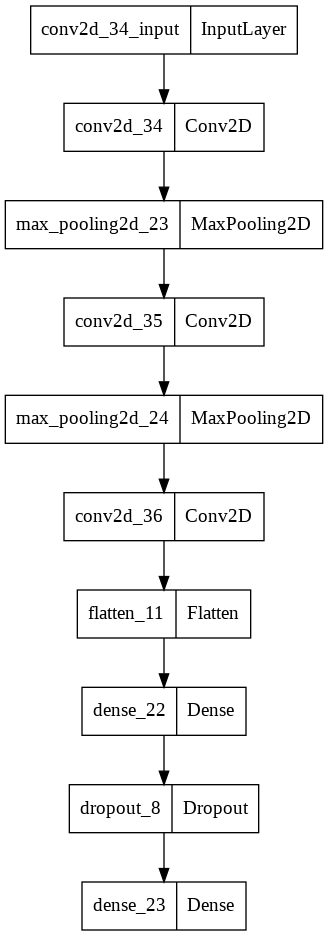

In [ ]:
plot_model(model_best)

In [ ]:
test_model(model_best)

10/10 [==============================] - 0s 23ms/step - loss: 0.3073 - acc: 0.8906

---------------------------------
Accuracy: 89.06 %
Loss: 30.73 %
---------------------------------



(336,)
(336, 150, 150, 1)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90       179
         1.0       0.91      0.84      0.87       157

    accuracy                           0.89       336
   macro avg       0.89      0.88      0.89       336
weighted avg       0.89      0.89      0.89       336



Text(0.5, -6.819805153394636, 'Predicted label')

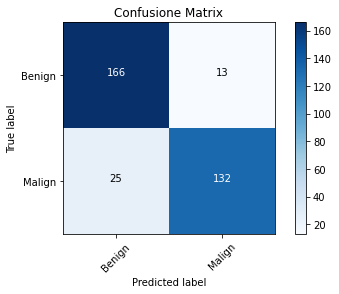

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+2,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

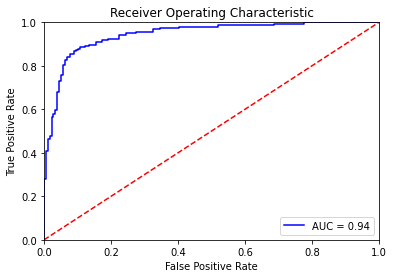

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()